# Predict the type of stocks (SELL/BUY)

Lihao Liu
Zhen Fang

## Summary of Findings


### Introduction
Given the stocks dataframe, we are interested in predicting the <mark>whether a trade is a BUY or SELL from 2020 to 2021 using binary classification</mark>, and our response variable would be **"type"** in the dataframe. We choose "type" as response variable because while analyzing representatives' trading records, trading type is an essential factor and it might be dependent to multiple factors. We didn't include data from year 2022 because we cannot predict future transaction type without present data.

Response Variable: **"type"**

Metrix: **Accuracy**. We do not choose F1-score because it's more useful when there are significant effects if false predictions occur. Thus, as accuracy is a direct and easy presentation of classifier's quality, we decide to use Accuracy as the metrix.

### Baseline Model
For baseline model,we choose **“transaction date”(nominal) and “representative”(nominal)** as features in a DecisionTreeClassifier with max_depth = 4. Since we only want to figure out transactions during 2020 and 2021, we change "transcation date" column from year-month-date to year_month as string. Thus, we have two nomial categoricla features through using OneHotEncoder. However, the Accuracy indicates (0.5545181727242414) our baseline model is **not a really good model** in generalizing to unseen data. Moreover, based on the confusion matrix, we can see that our model has a high false negative.


### Final Model
For final model,we choose **“transaction date”(nominal), “representative”(nominal), "owner"(nominal) and "amount"(ordinal)** as features in a RandomForestClassifier with **max_depth = 70 and n_neighbors = 7**, since Decisiontreeclassifier gives too much false positives. Through manual loops, we concluded to use **Randomforestclassifier with tree depth = 70**. Here, we further cleaned the dataset through merging different values with same meanings and dropping null values. The Accuracy in this model is approximately **0.678144**, which is much better than the one given in the baseline model (0.5545181727242414) and having much **less False Negatives and much more True Positives**. Also, compared to Decisiontreeclassifier (accuracy = 0.665096), RandomForestClassifier provides with **higher accuracy**, suggesting that **RandomForestClassifier is slightly better than Decisiontreeclassifier**.

The reason why we decide to choose "owner" and "amount" as new features is because these two columns provide us meaningful ranges, unlike "ticker" or "ptr_link" that are too random and don't actually serve as useful characteristics. 

### Fairness Analysis
In fairness analysis, we wonder if our model perform better in group whose transaction amount is larger than 500,000 than group whose transaction amount is smaller or equal to 500,000. To observe the result, we use permutation test with following hypotheses.<br>
**Null Hypothesis**: Our model is fair. It's precision for amount larger than 500,000 and amount smaller or equal to 500,000 are same. Any differences are due to random chance. <br>
**Alternative Hypothesis**: Our model is unfair. Its precision for amount larger than 500,00 is greater than amount smaller or equal to 500,000. <br>
<br>
P-value: **0.525**

As a result, our p-value is relatively large(0.525) and thus we fail to reject our null hypothesis that our model is fair. In other words, it's precision for amount larger than 500,000 and amount smaller or equal to 500,000 are the same. Thus, our conclusion is that our model is fair. The precision differnece between group whose transaction amount is larger than 500,000 and group whose transaction amount is smaller or equal to 500,000 is due to random chance.

## Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Baseline Model

Import needed functions

In [2]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

### Data Cleaning: 
Take the dataset "stock" in all_transactions.csv and define transaction range from year of 2020 and 2021, and drop columns we don't need.

In [78]:
df = pd.read_csv("all_transactions.csv")
df['transaction_date']=df.transaction_date.str.split(\
             '-').apply(lambda x: x[0]+'_'+x[1])
year = df['transaction_date'].str.split('_'\
            ).apply(lambda x :x[0]).astype(int)
df = df[(year==2021)|(year ==2020)]
df = df.drop(columns = ["ticker", "asset_description", \
                        "ptr_link", "district"])
df.head()

,disclosure_year,disclosure_date,transaction_date,owner,type,amount,representative,cap_gains_over_200_usd
0,2021,10/04/2021,2021_09,joint,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,False
1,2021,10/04/2021,2021_09,joint,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,False
2,2021,10/04/2021,2021_09,joint,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,False
3,2021,10/04/2021,2021_09,joint,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,False
4,2021,10/04/2021,2021_09,self,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,False


Only pay attention to "purchase", "sale_full" and "sale_partial" in transaction "type" and convert the types of stocks into numeric representations.

In [4]:
df["type"].value_counts()

purchase        6438
sale_full       3697
sale_partial    1859
exchange         109
Name: type, dtype: int64

Select rows include 'purchase', 'sale_full', or 'sale_partial' in type column. 

In [79]:
df= df[(df['type']=='purchase')|(df['type']=='sale_full'\
                    )|(df['type']=='sale_partial')]
df.head()

,disclosure_year,disclosure_date,transaction_date,owner,type,amount,representative,cap_gains_over_200_usd
0,2021,10/04/2021,2021_09,joint,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,False
1,2021,10/04/2021,2021_09,joint,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,False
2,2021,10/04/2021,2021_09,joint,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,False
3,2021,10/04/2021,2021_09,joint,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,False
4,2021,10/04/2021,2021_09,self,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,False


Since both sale_full and sale_partial belong to SELL, we first convert all sale_full and sale_partial to sell and then replace them with binary values 0 and 1

In [7]:
df2 = df.copy()
df2["type"] = df2["type"].replace("sale_partial","sell")
df2["type"] = df2["type"].replace("sale_full","sell")

In [8]:
df2["type"].value_counts()

purchase    6438
sell        5556
Name: type, dtype: int64

In [9]:
replace = {"purchase":0, "sell":1}
df2["type"] = df2["type"].replace(replace)
df2.head()

,disclosure_year,disclosure_date,transaction_date,owner,type,amount,representative,cap_gains_over_200_usd
0,2021,10/04/2021,2021_09,joint,0,"$1,001 - $15,000",Hon. Virginia Foxx,False
1,2021,10/04/2021,2021_09,joint,0,"$1,001 - $15,000",Hon. Virginia Foxx,False
2,2021,10/04/2021,2021_09,joint,0,"$15,001 - $50,000",Hon. Virginia Foxx,False
3,2021,10/04/2021,2021_09,joint,0,"$15,001 - $50,000",Hon. Virginia Foxx,False
4,2021,10/04/2021,2021_09,self,1,"$1,001 - $15,000",Hon. Alan S. Lowenthal,False


In [332]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df2[[\
            'transaction_date', 'representative']], \
                df2['type'],random_state=1)

In [333]:
#preprocessing of the columns
preproc = ColumnTransformer(
   [
        ('ohe', OneHotEncoder(handle_unknown = 'ignore'\
            ), ['transaction_date','representative'])
     
    ]
    ,remainder = 'passthrough'
)

In [334]:
#create the pipeline
pl = Pipeline([
    ('preprocessor', preproc),
    ('classifier', DecisionTreeClassifier(max_depth = 4))
])

In [335]:
#fit the model to the training data
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['transaction_date',
                                                   'representative'])])),
                ('classifier', DecisionTreeClassifier(max_depth=4))])

In [336]:
y_pred_test = pl.predict(X_test)
y_pred_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [337]:
pl.score(X_test, y_test)

0.5545181727242414

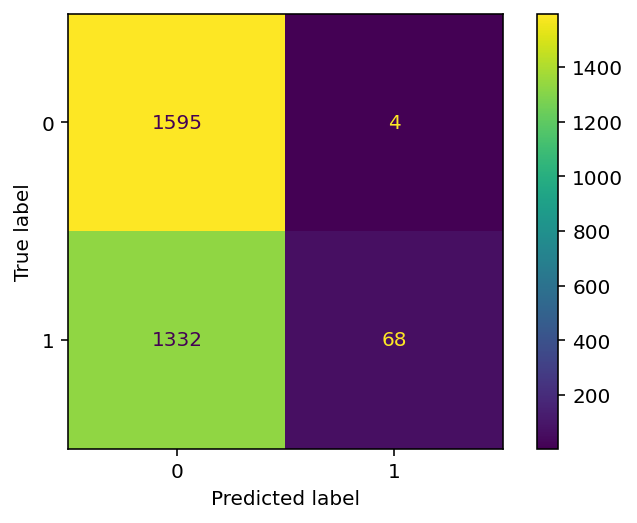

In [230]:
metrics.plot_confusion_matrix(pl, X_test, y_test)

### Final Model

In [18]:
df2.head()

,disclosure_year,disclosure_date,transaction_date,owner,type,amount,representative,cap_gains_over_200_usd
0,2021,10/04/2021,2021_09,joint,0,"$1,001 - $15,000",Hon. Virginia Foxx,False
1,2021,10/04/2021,2021_09,joint,0,"$1,001 - $15,000",Hon. Virginia Foxx,False
2,2021,10/04/2021,2021_09,joint,0,"$15,001 - $50,000",Hon. Virginia Foxx,False
3,2021,10/04/2021,2021_09,joint,0,"$15,001 - $50,000",Hon. Virginia Foxx,False
4,2021,10/04/2021,2021_09,self,1,"$1,001 - $15,000",Hon. Alan S. Lowenthal,False


### Data cleaning:
Since now we need to take "owner" and "amount" as features, we need to drop rows with null values

In [19]:
df2["owner"].value_counts()

joint        3847
self         2551
--            725
dependent     356
Name: owner, dtype: int64

In [20]:
df2["amount"].value_counts()

$1,001 - $15,000            8318
$15,001 - $50,000           1950
$50,001 - $100,000           618
$100,001 - $250,000          489
$1,001 -                     236
$250,001 - $500,000          185
$500,001 - $1,000,000        124
$1,000,001 - $5,000,000       29
$1,000,000 +                  28
$5,000,001 - $25,000,000       8
$1,000 - $15,000               4
$15,000 - $50,000              3
$50,000,000 +                  1
$1,000,000 - $5,000,000        1
Name: amount, dtype: int64

In this case, "--" and "\\$1,001 -" values are all null values, and thus we need to get rid of them. Also, there are some values meaning the same although in different representations, so we need to classify them as the same. In this case, "\\$1,001 - \\$ 15,000" and "\\$1,000 - \\$ 15,000" mean the same, "\\$15,001 - \\$ 50,000" and "\\$15,000 - \\$ 50,000" mean the same, "\\$1,000,001 - \\$ 5,000,000", "\\$1,000,000 +" and "\\$1,000,000 - \\$5,000,000" mean the same, and "\\$1,000,000 - \\$ 5,000,000" also mean the same.

In [21]:
df3 = df2.copy()

df3 = df3[df3["owner"]!= "--"]

df3 = df3[df3["amount"]!= "$1,001 -"]

df3["amount"] = df3["amount"].replace(\
                    "$1,001 - $15,000","$1,000 - $15,000")
df3["amount"] = df3["amount"].replace(\
            "$1,000,001 - $5,000,000","$1,000,000 - $5,000,000")
df3["amount"] = df3["amount"].replace(\
                "$15,000 - $50,000","$15,001 - $50,000")
df3["amount"] = df3["amount"].replace(\
                "$1,000,000 +","$1,000,000 - $5,000,000")
df3["amount"] = df3["amount"].replace(\
            "$1,000,000 - $5,000,000","$1,000,001 - $5,000,000")

df3["owner"].value_counts()

joint        3839
self         2329
dependent     356
Name: owner, dtype: int64

In [22]:
df3["amount"].value_counts()

$1,000 - $15,000            7727
$15,001 - $50,000           1885
$50,001 - $100,000           589
$100,001 - $250,000          466
$250,001 - $500,000          180
$500,001 - $1,000,000        119
$1,000,001 - $5,000,000       58
$5,000,001 - $25,000,000       8
$50,000,000 +                  1
Name: amount, dtype: int64

We will now convert the "amount" column into ordinal values from 0 to 8, 0 represents \\$1001-\\$15000 and 8 represents \\$50000000+

In [23]:
amount = {"$1,000 - $15,000":0,"$15,001 - $50,000":1,\
    "$50,001 - $100,000":2,"$100,001 - $250,000":3,\
        "$250,001 - $500,000":4,
          "$500,001 - $1,000,000":5,\
    "$1,000,001 - $5,000,000":6,\
    "$5,000,001 - $25,000,000":7, "$50,000,000 +":8}
df3["amount"] = df3["amount"].replace(amount)
df3.head()

,disclosure_year,disclosure_date,transaction_date,owner,type,amount,representative,cap_gains_over_200_usd
0,2021,10/04/2021,2021_09,joint,0,0,Hon. Virginia Foxx,False
1,2021,10/04/2021,2021_09,joint,0,0,Hon. Virginia Foxx,False
2,2021,10/04/2021,2021_09,joint,0,1,Hon. Virginia Foxx,False
3,2021,10/04/2021,2021_09,joint,0,1,Hon. Virginia Foxx,False
4,2021,10/04/2021,2021_09,self,1,0,Hon. Alan S. Lowenthal,False


Now, let's create pipelines and compare between a Decision Tree Classifier and Random Forest Classifier to see which model we better use

In [24]:
#split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(\
            df3[['transaction_date', 'representative',\
        'amount','owner']], df3['type'],random_state=1)

In [431]:
accuracy_test = []
accuracy_train = []

accuracy_test2 = []
accuracy_train2 = []

#def convert(amount):
#    amounts = {"$1,000 - $15,000":0,
#   "$15,001 - $50,000":1,"$50,001 - $100,000":2,
#"$100,001 - $250,000":3,"$250,001 - $500,000":4,
#          "$500,001 - $1,000,000":5,"$1,000,001 - $5,000,000":6,
#"$5,000,001 - $25,000,000":7, "$50,000,000 +":8}
#    df3[amount] = df3[amount].replace(amounts)
#    return df3[amount]


#create the pipeline
for i in range(1, 101):
    #preprocessing of the columns
    pipe = Pipeline([('onehot', \
                    OneHotEncoder(handle_unknown = 'ignore'))])
    preproc2 = ColumnTransformer(
       [
           #("convert",FunctionTransformer(convert), ['amount']), 
           ('pipe', OneHotEncoder(\
                handle_unknown = 'ignore'),\
            ['transaction_date', 'representative','owner'])
        ]
         ,remainder = 'passthrough'
    )   
    
    p2 = Pipeline([
        ('preprocessor', preproc2),
        ('classifier', DecisionTreeClassifier(max_depth = i))
    ])
    
    #fit the model to the training data
    p2.fit(X_train2, y_train2)
    
    #y_pred_test2 = p2.predict(X_test2)
    #y_pred_train2 = p2.predict(X_train2)
    
    accuracy_test.append(p2.score(X_test2, y_test2))
    accuracy_train.append(p2.score(X_train2, y_train2))
    
    
    
    p3 = Pipeline([
        ('preprocessor', preproc2), 
        ('clf', RandomForestClassifier(\
        max_depth=i, n_estimators=7)) 
        # Uses 7 separate decision trees
    ])
    p3.fit(X_train2, y_train2)
        
    #y_pred_test3 = p3.predict(X_test2)
    #y_pred_train3 = p3.predict(X_train2)
        
    accuracy_test2.append(p3.score(X_test2, y_test2))
    accuracy_train2.append(p3.score(X_train2, y_train2))
        

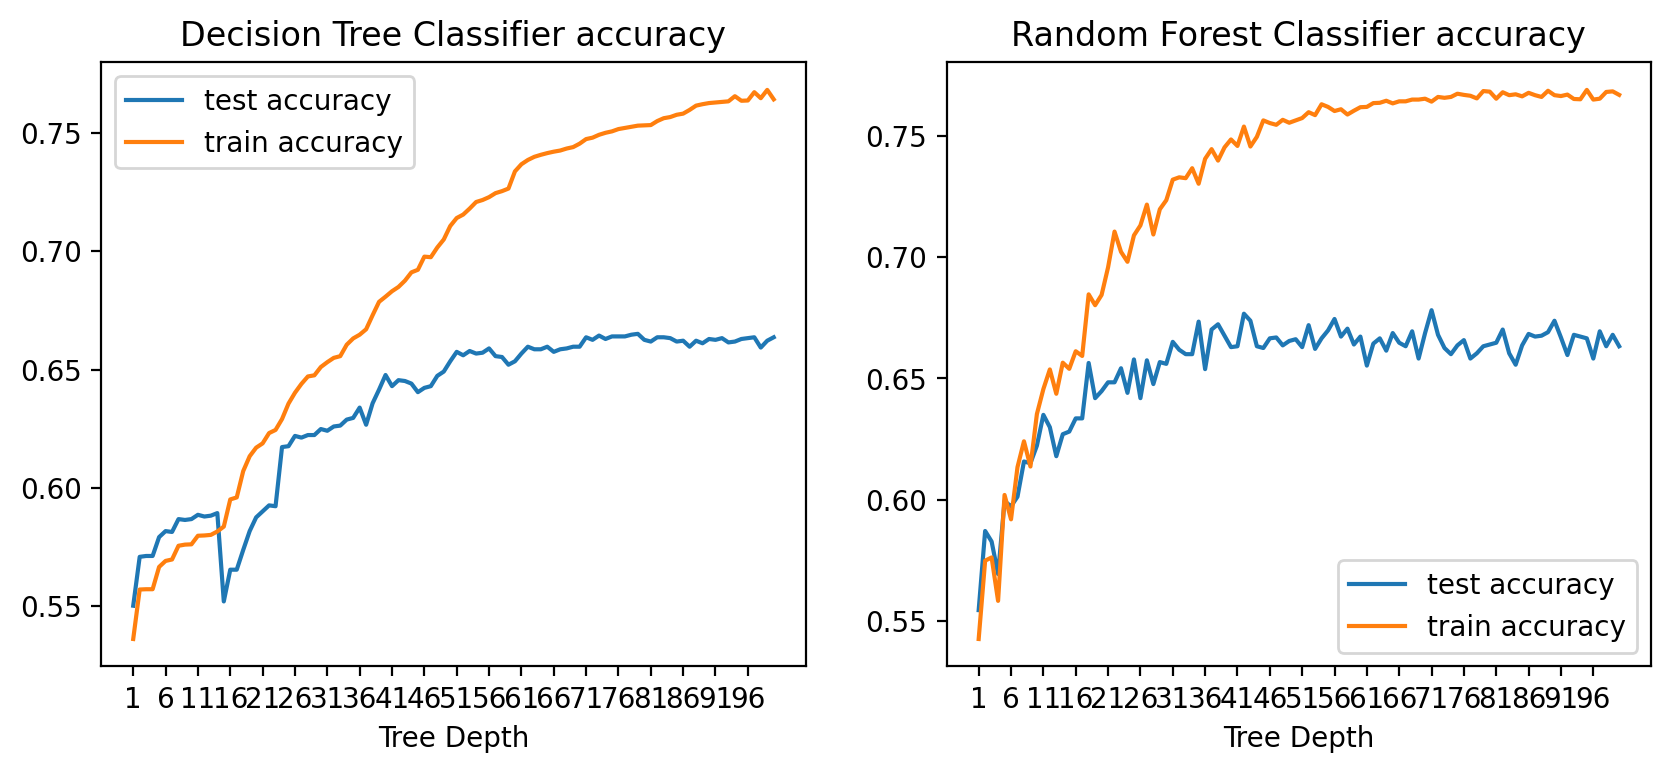

In [432]:
hyp = np.arange(1, 101)


plt.subplots(1, 2, figsize=(10, 4), dpi=100)

plt.subplot(1, 2, 1)
plt.plot(hyp, accuracy_test, label='test accuracy')
plt.plot(hyp, accuracy_train, label='train accuracy')
plt.legend()
plt.xlabel('Tree Depth')
plt.xticks(np.arange(1, 101, 5))
plt.title('Decision Tree Classifier accuracy')

plt.subplot(1, 2, 2)
plt.plot(hyp, accuracy_test2, label='test accuracy')
plt.plot(hyp, accuracy_train2, label='train accuracy')
plt.legend()
plt.xlabel('Tree Depth')
plt.xticks(np.arange(1, 101, 5))
plt.title('Random Forest Classifier accuracy');

In [433]:
dataframe = pd.DataFrame()
dataframe["DT_test_accuracy"] = accuracy_test


dataframe2 = pd.DataFrame()
dataframe2["RF_test_accuracy"] = accuracy_test2

dataframe.head()

,DT_test_accuracy
0,0.550199
1,0.570859
2,0.571221
3,0.571221
4,0.579195


In [434]:
dataframe2.head()

,RF_test_accuracy
0,0.554549
1,0.587169
2,0.582820
3,0.569409
4,0.599493


let's see at which depth the Accuracy is the highest, and it turns out that the Accuracy of Decision Tree Classifier is the highest when the tree depth is 78, and the Accuracy of Random Forest Classifier is the highest when the tree depth is 70

In [435]:
dataframe.idxmax()

DT_test_accuracy    78
dtype: int64

In [441]:
dataframe.iloc[78]

DT_test_accuracy    0.665096
Name: 78, dtype: float64

In [442]:
dataframe2.idxmax()

RF_test_accuracy    70
dtype: int64

In [443]:
dataframe2.iloc[70]

RF_test_accuracy    0.678144
Name: 70, dtype: float64

Let's visualize the prediction of both classifier

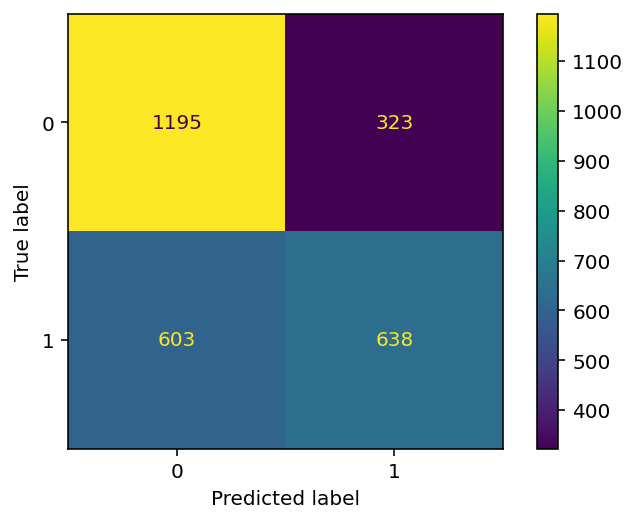

In [439]:
pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown = 'ignore'))])
preproc2 = ColumnTransformer(
   [
        ('pipe', pipe, ['transaction_date', 'representative','owner'])
     
    ]
    ,remainder = 'passthrough'
)   
p2 = Pipeline([
    ('preprocessor', preproc2),
    ('classifier', DecisionTreeClassifier(max_depth = 77))
])
    
#fit the model to the training data
p2.fit(X_train2, y_train2)
metrics.plot_confusion_matrix(p2, X_test2, y_test2)

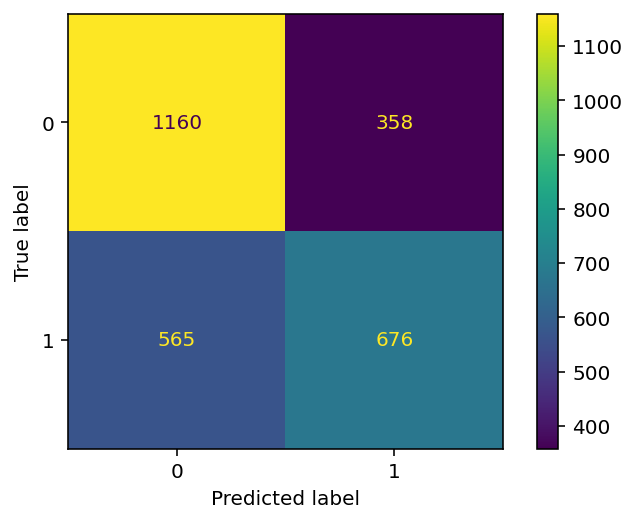

In [440]:
pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preproc2 = ColumnTransformer(
   [
        ('pipe', pipe, ['transaction_date', 'representative','owner'])
     
    ]
    ,remainder = 'passthrough'
)   

p3 = Pipeline([
    ('preprocessor', preproc2), 
    ('clf', RandomForestClassifier(max_depth=41, n_estimators=7))
    # Uses 7 separate decision trees
])
p3.fit(X_train2, y_train2)

#fit the model to the training data
p3.fit(X_train2, y_train2)
metrics.plot_confusion_matrix(p3, X_test2, y_test2)

From the process shown above, we prefer to use Random Forest Classifier as our model since the accuracy seem more reliable and it makes more stable predictions. Unlike Decision Tree Classifier, the Random Forest Classifier gives comparatively balanced False Negative and False Positive predictions.

### Fairness Analysis

We wonder if our model perform better on larger amount(amout>500,000) than smaller amount (amount <=500,000).

Firstly, we manually binarize 'amount' smaller or equal to 500,000 to 0, and 'amount' larger than 500,000 to 1. From our df_3, we observe that amount less or equal to 500,000 are in groups {0,1,2,3,4}, and amount larger than 500,000 are in groups {5,6,7,8}. Thus, we replace groups in df_3 with 0 and 1.

In [64]:
#replace 0-8 as 0-1 as description
replace = {0:0, 1:0,2:0,3:0,4:0,5:1,6:1,7:1,8:1}
df_fair = df3.copy()
df_fair['amount'] = df3['amount'].replace(replace)
df_fair.head()

,disclosure_year,disclosure_date,transaction_date,owner,type,amount,representative,cap_gains_over_200_usd
0,2021,10/04/2021,2021_09,joint,0,0,Hon. Virginia Foxx,False
1,2021,10/04/2021,2021_09,joint,0,0,Hon. Virginia Foxx,False
2,2021,10/04/2021,2021_09,joint,0,0,Hon. Virginia Foxx,False
3,2021,10/04/2021,2021_09,joint,0,0,Hon. Virginia Foxx,False
4,2021,10/04/2021,2021_09,self,1,0,Hon. Alan S. Lowenthal,False


For Fairness Analysis, our null hythothesis and alternative hypothesis are: <br>
**Null Hypothesis**: Our model is fair. It's precision for amount larger than 500,000 and amount smaller or equal to 500,000 are same. Any differences are due to random chance. <br>
**Alternative Hypothesis**: Our model is unfair. Its precision for amount larger than 500,00 is greater than amount smaller or equal to 500,000. 
 

In [65]:
#permutation test for precision
n = 1000
new_df = df_fair.copy()
precision = []
for i in range(n):
    #assign new shuffuled column 'new'
    new_df['new']=np.random.permutation(df_fair['amount'])
    #seperate new_df to rows with 'amount'==0 and 'amount'==1
    smaller = new_df[new_df['new']==0]
    larger = new_df[new_df['new']==1]
    #split the data into training and testing sets
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(\
            smaller[['transaction_date', 'representative',\
        'amount','owner']], smaller['type'],random_state=1)
    y_pred_test_s = p3.predict(X_test_s)
    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(\
        larger[['transaction_date', 'representative','amount',\
                'owner']], larger['type'],random_state=1)
    y_pred_test_l = p3.predict(X_test_l)
    #calculate the difference of precision score of smaller 
    #amount group - larger amount group
    precision.append(metrics.precision_score(y_test_s, \
            y_pred_test_s)-metrics.precision_score(\
                        y_test_l, y_pred_test_l))
    

In [66]:
#calculate observe difference in precision between small amount and large amount
df_fair_s= df_fair[df_fair['amount']==0]
df_fair_l= df_fair[df_fair['amount']==1]
#seperate df_fair to two groups: amount ==0 and amount==1
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(\
            df_fair_s[['transaction_date', 'representative',\
            'amount','owner']], df_fair_s['type'],random_state=1)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(\
            df_fair_l[['transaction_date', 'representative',\
            'amount','owner']], df_fair_l['type'],random_state=1)
y_pre_test_s = p3.predict(X_test_s)
y_pre_test_l = p3.predict(X_test_l) #train and get precision
obs_diff = metrics.precision_score(y_test_s, \
            y_pre_test_s)-metrics.precision_score(\
                    y_test_l, y_pre_test_l)
#calcualte differences in two groups's precision
precision = pd.Series(precision)
pval = (precision>=obs_diff).sum()/n
pval

0.525

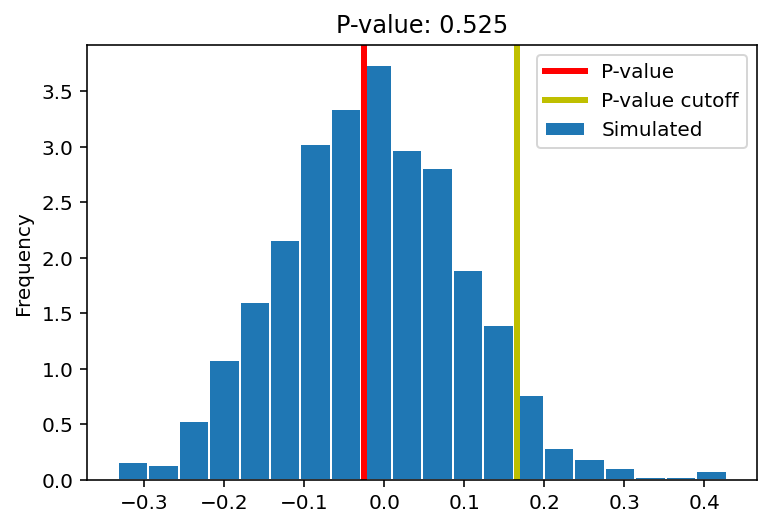

In [67]:
precision.plot(kind='hist', density=True, ec='w', bins=20,\
            title=f'P-value: {pval}', label='Simulated')
plt.axvline(x=obs_diff, color='red', linewidth=3, label='P-value')

perc = np.percentile(precision, 95) # 5% significance level
plt.axvline(x=perc, color='y', linewidth=3, label='P-value cutoff')

plt.legend();

P-value is 0.525 and we fail to reject our null hypothesis that our model is fair. Our conclusion is that there is no differences when predicting sale or purchase in group whose transcation amount is larger than 500,000 and in group whose transaction amount is smaller or equal to 500,000. Our model is fair.